# NT + ESM-2 ZERO-SHOT Ver


### 1) Split parquet into train/val/test (chr20/21 as test)


In [1]:
from split_data import main as split_main
from config import RAW_PARQUET
split_main(RAW_PARQUET)

Saved:
  train: 114568 -> d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\train.parquet
  val  : 20219 -> d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\val.parquet
  test : 4562 -> d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\test.parquet


### 2) Precompute embeddings (NT + ESM-2)


In [2]:
%env TOKENIZERS_PARALLELISM=false
from precompute_embeddings import main as emb_main
emb_main()

env: TOKENIZERS_PARALLELISM=false


c:\Users\Dung\anaconda3\envs\stable\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Loading NT...


Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading ESM-2...


c:\Users\Dung\anaconda3\envs\stable\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dung\.cache\huggingface\hub\models--facebook--esm2_t33_650M_UR50D. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular 

Embedding split d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\train.parquet (114568 rows)


100%|██████████| 28642/28642 [16:39<00:00, 28.65it/s]


[saved] d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\embeddings\train_embeddings.pt
Embedding split d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\val.parquet (20219 rows)


100%|██████████| 5055/5055 [02:56<00:00, 28.71it/s]


[saved] d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\embeddings\val_embeddings.pt
Embedding split d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\data\test.parquet (4562 rows)


100%|██████████| 1141/1141 [00:39<00:00, 28.68it/s]


[saved] d:\Biosequence\Bio_sequence_Research_AITALAB-main\train\task3_variant_prediction\embeddings\test_embeddings.pt


### 3) Train fusion classifier

Để theo dõi tiến độ train trong tensorboard:

- Mở terminal -> nhập: tensorboard --logdir train/task3_variant_prediction/runs -> truy cập vào link được in ra


In [4]:
EXP_NAME = "experiment_11_cross_attn_gated_fusion_diff"

TRAINING CONFIGURATION:
  Experiment Name: experiment_11_cross_attn_gated_fusion_diff
  Device: cuda
  Mode: both
  Fusion Method: cross_attn
  Use Gating: True
  Feature Mode: diff
  Learning Rate: 0.0001
  Epochs: 30
  Batch Size: 128
  Patience: 5
  Dropout: 0.3
  Seed: 42
  Proj Dim: 512
  Fusion Hidden: [512, 256]
  Log Dir: runs\experiment_11_cross_attn_gated_fusion_diff
  Experiment Dir: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff

============================== MODEL SUMMARY ==============================
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
FusionClassifier                         [128, 1280]               [128]                     --                        --                        --
├─ModalityProjector: 1-1                 [128, 1280]               [128, 512]               

[1] Train Loss: 0.1862 | Val Loss: 0.1551 | Train Acc: 0.9282 | Val Acc: 0.9403
--> Saved best model checkpoint to d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\best_fusion_model.pt


[2] Train Loss: 0.1401 | Val Loss: 0.1584 | Train Acc: 0.9459 | Val Acc: 0.9420


[3] Train Loss: 0.1118 | Val Loss: 0.1810 | Train Acc: 0.9576 | Val Acc: 0.9402


[4] Train Loss: 0.0814 | Val Loss: 0.1885 | Train Acc: 0.9694 | Val Acc: 0.9407


[5] Train Loss: 0.0574 | Val Loss: 0.2531 | Train Acc: 0.9786 | Val Acc: 0.9381


[6] Train Loss: 0.0304 | Val Loss: 0.3526 | Train Acc: 0.9890 | Val Acc: 0.9395
Early stopping triggered.

--- Testing with Best Model ---


[TEST] Loss: 0.1644 | AUC: 0.9342 | MCC: 0.8702 | Acc: 0.9364 | Spec: 0.9503
[TEST] Balanced Acc: 0.9342 | F1_macro: 0.9351 | Precision: 0.9333 | Recall: 0.9181

--- Gating Analysis ---
Analyzing gating weights on test set...


100%|██████████| 36/36 [00:01<00:00, 30.24it/s]


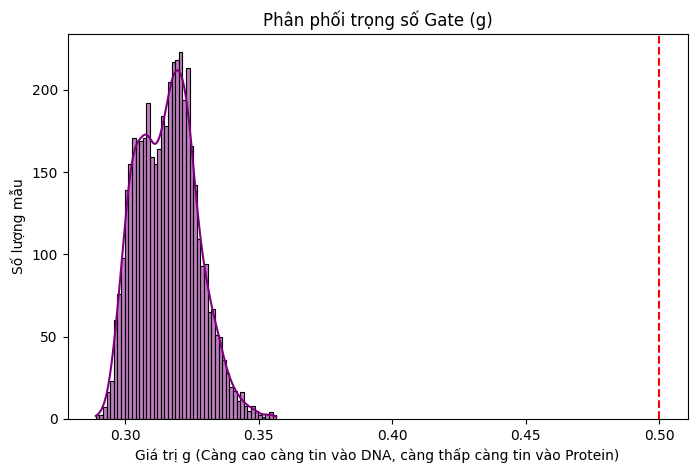

Số lượng mẫu phụ thuộc nhiều vào DNA (g > 0.7): 0 / 4562

--- TOP 5 SAMPLES PRIORITIZING DNA ---
Empty DataFrame
Columns: [CHROM, POS, REF, ALT, gate_dna_weight, true_label, is_correct]
Index: []

✓ Experiment saved to: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff
  - Config: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff\config.json
  - Args: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff\args.json
  - Results: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff\results.json
  - Model: d:\Bio_sequence_Research_AITALAB\train\task3_variant_prediction\embeddings\experiments\experiment_11_cross_attn_gated_fusion_diff\best_model.pt


{'acc': 0.9364314079284668,
 'auc': 0.9342079162597656,
 'balanced_acc': 0.9342079758644104,
 'f1_macro': 0.9350639581680298,
 'mcc': 0.870223879814148,
 'precision': 0.9332988858222961,
 'recall': 0.918107807636261,
 'specificity': 0.9503081440925598,
 'loss': 0.1643994603680054}

In [5]:
from train import train
from config import LR, EPOCHS, BATCH_SIZE, PATIENCE, DROPOUT, SEED, PROJ_DIM, FUSION_HIDDEN, WEIGHT_DECAY, MODE, FUSION_METHOD, FEATURE_MODE, USE_GATING
import argparse

parser = argparse.ArgumentParser(description="Train fusion classifier with enhanced features.")
parser.add_argument("--mode", type=str, default= MODE, choices=['dna','prot',MODE])
parser.add_argument("--fusion_method", type=str, default= 'cross_attn', choices=[FUSION_METHOD, 'cross_attn'])
parser.add_argument("--use_gating", type=str, default= True, choices=[USE_GATING, True])
parser.add_argument("--feature_mode", type=str, default= 'diff', choices=[FEATURE_MODE, 'ref_alt', 'diff', 'ref', 'alt'])
parser.add_argument("--proj_dim", type=int, default=PROJ_DIM)
parser.add_argument("--fusion_hidden", type=list, default=FUSION_HIDDEN)
parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
parser.add_argument("--epochs", type=int, default=EPOCHS)
parser.add_argument("--batch_size", type=int, default=BATCH_SIZE)
parser.add_argument("--patience", type=int, default=PATIENCE)
parser.add_argument("--dropout", type=float, default=0.3)
parser.add_argument("--weight_decay", type=float, default=WEIGHT_DECAY, help="L2 regularization lambda")
parser.add_argument("--seed", type=int, default=SEED)
parser.add_argument("--exp_name", type=str, default=EXP_NAME, help="Experiment name (auto-generated if not provided)")
parser.add_argument("--log_dir", type=str, default=None, help="TensorBoard log directory (auto: runs/exp_name)")

args = parser.parse_args([])

result = train(args)
result

### 4) Xem lại kết quả experiments

Các experiments được lưu tự động trong `embeddings/experiments/<exp_name>/`


In [6]:
# Xem danh sách tất cả experiments
import os
import json
import pandas as pd

exp_base_dir = "embeddings/experiments"
if os.path.exists(exp_base_dir):
    experiments = []
    for exp_name in os.listdir(exp_base_dir):
        exp_dir = os.path.join(exp_base_dir, exp_name)
        results_file = os.path.join(exp_dir, "results.json")
        if os.path.exists(results_file):
            with open(results_file, "r") as f:
                data = json.load(f)
                experiments.append({
                    "exp_name": exp_name,
                    "timestamp": data.get("timestamp", ""),
                    "test_auc": data["test_results"].get("auc", 0),
                    "test_acc": data["test_results"].get("acc", 0),
                    "test_mcc": data["test_results"].get("mcc", 0),
                    "test_balanced_acc": data["test_results"].get("balanced_acc", 0),
                    "test_f1_macro": data["test_results"].get("f1_macro", 0),
                    "test_precision": data["test_results"].get("precision", 0),
                    "test_specificity": data["test_results"].get("specificity", 0),
                    "test_recall": data["test_results"].get("recall", 0),
                    "best_val_loss": data.get("best_val_loss", 0),
                    "epochs": data.get("epochs_trained", 0),
                })
    
    if experiments:
        df = pd.DataFrame(experiments)
        df = df.sort_values("timestamp", ascending=False)
        print("Danh sách experiments:")
        print(df.to_string(index=False))
    else:
        print("Chưa có experiments nào.")
else:
    print(f"Thư mục {exp_base_dir} chưa tồn tại.")

Danh sách experiments:
                                          exp_name                  timestamp  test_auc  test_acc  test_mcc  test_balanced_acc  test_f1_macro  test_precision  test_specificity  test_recall  best_val_loss  epochs
        experiment_11_cross_attn_gated_fusion_diff 2026-01-18T17:20:36.037229  0.934208  0.936431  0.870224           0.934208       0.935064        0.933299          0.950308     0.918108       0.155082       6
experiment_10_cross_attn_gated_fusion_all_features 2026-01-18T17:14:37.883940  0.933090  0.936212  0.869778           0.933090       0.934714        0.939633          0.955701     0.910478       0.153865       6
              experiment_9_cross_attn_all_features 2026-01-18T15:52:35.059042  0.932912  0.936431  0.870277           0.932912       0.934881        0.942918          0.958398     0.907426       0.156113       7
                      experiment_8_cross_attn_diff 2026-01-18T15:45:30.003702  0.929617  0.930294  0.858111           0.929617   

In [ ]:
# Xem chi tiết một experiment cụ thể
exp_name = EXP_NAME  # Thay bằng exp_name muốn xem

exp_dir = f"embeddings/experiments/{exp_name}"
if os.path.exists(exp_dir):
    print(f"=== Experiment: {exp_name} ===\n")
    
    # Xem config
    config_file = os.path.join(exp_dir, "config.json")
    if os.path.exists(config_file):
        with open(config_file, "r") as f:
            config = json.load(f)
        print("Config:")
        for k, v in config.items():
            print(f"  {k}: {v}")
        print()
    
    # Xem cấu trúc Model
    summary_file = os.path.join(exp_dir, "model_summary.txt")
    if os.path.exists(summary_file):
        print("Model Architecture Summary:")
        with open(summary_file, "r", encoding="utf-8") as f:
            print(f.read())
        print()

    # Xem results
    results_file = os.path.join(exp_dir, "results.json")
    if os.path.exists(results_file):
        with open(results_file, "r") as f:
            results = json.load(f)
        print("Results:")
        print(f"  Best Val Loss: {results.get('best_val_loss', 0):.4f}")
        print(f"  Test AUC: {results['test_results'].get('auc', 0):.4f}")
        print(f"  Test Acc: {results['test_results'].get('acc', 0):.4f}")
        print(f"  Test MCC: {results['test_results'].get('mcc', 0):.4f}")
        print(f"  Test Balanced Acc: {results['test_results'].get('balanced_acc', 0):.4f}")
        print(f"  Test F1_macro: {results['test_results'].get('f1_macro', 0):.4f}")
        print(f"  Test Precision: {results['test_results'].get('precision', 0):.4f}")
        print(f"  Test Specificity: {results['test_results'].get('specificity', 0):.4f}")
        print(f"  Test Recall: {results['test_results'].get('recall', 0):.4f}")
        print(f"  Epochs Trained: {results.get('epochs_trained', 0)}")
else:
    print(f"Experiment '{exp_name}' không tồn tại.")

=== Experiment: experiment_7 ===

Config:
  exp_name: experiment_7
  timestamp: 2026-01-15T18:16:50.000655
  mode: both
  lr: 0.0001
  epochs: 30
  batch_size: 128
  patience: 5
  dropout: 0.3
  seed: 42
  proj_dim: 512
  fusion_hidden: [512, 256]
  log_dir: runs\experiment_7

Model Architecture Summary:
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
FusionClassifier                         [128, 1280]               [128]                     --                        --                        --
├─ModalityProjector: 1-1                 [128, 1280]               [128, 512]                --                        --                        --
│    └─Sequential: 2-1                   [128, 3840]               [128, 512]                --                        --                        --
│    │    └─Linear: 3-1                  [128, 3840]               [128, 512]                1,

# NT + ESM-2 FINE-TUNED Ver
